In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#load data
data_test=pd.read_csv("https://raw.githubusercontent.com/VinitaSilaparasetty/hand-gesture-recognition/main/sign_mnist_test.csv")
data_train=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Datasets/sign_mnist_train.csv")

In [4]:
def show_img(img, df):
    label = df['label'][img]
    pixels = df.iloc[img, 1:]
    pixels = np.array(pixels, dtype='uint8')
    pixels = pixels.reshape((28, 28))

    plt.title(f'Label is {label}')
    plt.imshow(pixels, cmap='gray')
    plt.show()

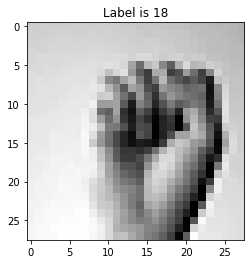

In [5]:
show_img(20, data_train)

In [6]:
data_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,172,175,185,183,184,185,185,185,183,183,182,181,178,86,88,93,96,108,125,137,145,149,154,160,...,145,123,78,162,239,227,229,226,226,225,224,222,89,91,94,111,136,154,167,184,125,3,166,225,195,188,172,185,161,122,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,209,208,207,207,209,208,210,210,207,209,209,208,209,210,209,207,208,209,207,206,208,209,208,208,210,211,210,211,209,209,...,85,80,84,151,238,255,255,250,237,245,250,232,103,101,102,103,95,208,231,227,209,190,179,182,152,150,159,119,83,63,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,203,202,198,216,217,135,181,200,195,194,193,190,189,187,185,190,194,196,197,200,202,204,206,207,207,206,...,93,52,24,53,63,33,41,51,48,45,49,55,149,150,150,148,147,151,124,82,84,81,69,81,111,103,84,75,53,28,26,40,64,48,29,46,49,46,46,53


In [7]:
# extract train and test data

X_train = data_train.drop('label', axis=1).values
X_test = data_test.drop('label', axis=1).values
y_train = data_train['label'].values
y_test = data_test['label'].values

In [8]:
# Label Binarizer
lb = LabelBinarizer()

y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [9]:
# normalization

X_train = X_train/255
X_test = X_test/255

In [10]:
# reshape

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

## Data Augmentation

In [11]:
data_gen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False, 
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

data_gen.fit(X_train)

## Model

In [12]:
model = Sequential()

model.add(Conv2D(75, (3, 3), strides=1, padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))

model.add(Conv2D(50, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))

model.add(Conv2D(25, (3, 3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))

model.add(Flatten())

model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=24, activation='softmax'))

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 50)        200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0

In [15]:
# set parameters

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

In [16]:
model.fit(data_gen.flow(X_train, y_train, batch_size=128), epochs=20, validation_data=(X_test, y_test), callbacks=[learning_rate_reduction])

Epoch 1/20
215/215 [==============================] - 38s 35ms/step - loss: 1.6372 - accuracy: 0.5146 - val_loss: 4.5067 - val_accuracy: 0.0608
Epoch 2/20
215/215 [==============================] - 7s 32ms/step - loss: 0.1628 - accuracy: 0.9472 - val_loss: 1.5577 - val_accuracy: 0.5460
Epoch 3/20
215/215 [==============================] - 7s 33ms/step - loss: 0.0707 - accuracy: 0.9779 - val_loss: 0.1196 - val_accuracy: 0.9572
Epoch 4/20
215/215 [==============================] - 7s 33ms/step - loss: 0.0406 - accuracy: 0.9864 - val_loss: 0.0870 - val_accuracy: 0.9727
Epoch 5/20
215/215 [==============================] - 7s 33ms/step - loss: 0.0215 - accuracy: 0.9934 - val_loss: 0.0884 - val_accuracy: 0.9697
Epoch 6/20
215/215 [==============================] - 7s 32ms/step - loss: 0.0202 - accuracy: 0.9937 - val_loss: 0.1243 - val_accuracy: 0.9527

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/20
215/215 [==============================] - 7s 33m

In [17]:
# check final accuracy
model.evaluate(X_test, y_test)

225/225 [==============================] - 1s 2ms/step - loss: 0.0073 - accuracy: 0.9974


[0.0073227835819125175, 0.997350811958313]

## Save predictions

In [18]:
predictions = model.predict_classes(X_test)
for i in range(len(predictions)):
    if (predictions[i] >=9  or predictions[i] >= 25):
        predictions[i] += 1

predictions[:5]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([ 6,  5, 10,  0,  3])

In [19]:
# save model

model.save('hand_gesture1.h5')